<a href="https://colab.research.google.com/github/achmadbadri/UjiCoba/blob/main/Final_Code_4_16_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

In [ ]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style
from google.colab import files
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,31)
df = web.DataReader("ANTM.JK", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2018,11,13)
end = datetime.datetime(2019,12,31)
test_df = web.DataReader("ANTM.JK", 'yahoo', start, end) 
print(df.shape)
print(test_df.shape)

(1251, 6)
(292, 6)


In [ ]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1251,)


In [ ]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1215, 36, 1)
X_train:
[[879.27844238]
 [846.71258545]
 [818.21740723]
 [818.21740723]
 [822.28820801]
 [818.21740723]
 [797.86383057]
 [806.00531006]
 [806.00531006]
 [830.42956543]
 [818.21740723]
 [838.57110596]
 [879.27844238]
 [871.13696289]
 [850.78338623]
 [846.71258545]
 [822.28820801]
 [818.21740723]
 [822.28820801]
 [838.57110596]
 [830.42956543]
 [818.21740723]
 [814.14678955]
 [814.14678955]
 [822.28820801]
 [826.35888672]
 [846.71258545]
 [842.6418457 ]
 [826.35888672]
 [826.35888672]
 [842.6418457 ]
 [862.99554443]
 [862.99554443]
 [850.78338623]
 [858.92480469]
 [854.85406494]]


y_train: [[842.6418457]]



In [ ]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
85/85 [==============================] - 7s 48ms/step - loss: 0.0476 - val_loss: 0.0031
Epoch 2/20
85/85 [==============================] - 3s 37ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/20
85/85 [==============================] - 3s 36ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 4/20
85/85 [==============================] - 3s 36ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 5/20
85/85 [==============================] - 3s 36ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 6/20
85/85 [==============================] - 3s 37ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 7/20
85/85 [==============================] - 3s 36ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 8/20
85/85 [==============================] - 3s 36ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 9/20
85/85 [==============================] - 3s 37ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 10/20
85/85 [==============================] - 3s 36ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 11/

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 36, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


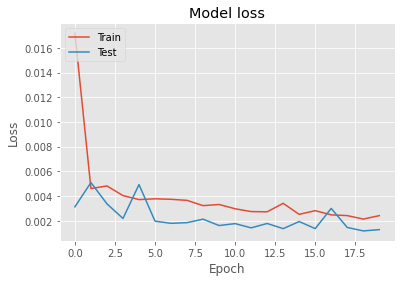

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


In [ ]:
predicted_y = pd.DataFrame(predicted_y)
org_y = pd.DataFrame(org_y)
describe = pd.DataFrame()
describe['True Price'] = org_y[0]
describe['Prediction'] = predicted_y[0]
describe['difference'] = org_y[0] - predicted_y[0]
describe['MAPE (%)'] = abs(describe['difference']/org_y[0]*100)
describe.describe()

,True Price,Prediction,difference,MAPE (%)
count,256.000000,256.000000,256.000000,256.000000
mean,892.390932,878.023010,14.368193,2.947887
std,110.112318,104.926117,32.109791,2.316107
min,666.902649,672.053162,-54.883362,0.008576
25%,816.209167,805.545135,-6.219360,1.189583
50%,878.944214,868.683746,11.803741,2.460580
75%,975.652557,957.177887,31.732529,4.301208
max,1164.591187,1089.776367,143.399170,12.313263


In [ ]:
describe.head(10)

,True Price,Prediction,difference,MAPE (%)
0,724.700562,743.171692,-18.471130,2.548795
1,734.493774,736.450684,-1.956909,0.266430
2,744.286987,731.370422,12.916565,1.735428
3,754.080261,730.154846,23.925415,3.172794
4,744.286987,733.050537,11.236450,1.509693
5,763.873535,734.813293,29.060242,3.804326
6,773.666809,740.390320,33.276489,4.301140
7,773.666809,748.479309,25.187500,3.255600
8,763.873535,755.845520,8.028015,1.050961
9,803.046509,759.050659,43.995850,5.478618


In [ ]:
a = np.array(describe['True Price'])
b = np.array(describe['Prediction'])

# MSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: %.2f" % mean_squared_error(a, b))

# The RMSE
print("RMSE: %.2f" % mean_squared_error(a, b, squared=False))

# The MAE
print("MAE: %.2f" % mean_absolute_error(a, b))

#Mean Absolute Percentange Error
c = (np.mean(np.abs((a - b) / a))) * 100
print('MAPE : ', c)

# Explained variance score: 1 is perfect prediction
from sklearn.metrics import r2_score
print('R2 score: %.2f' % r2_score(a, b))


MSE: 1233.46
RMSE: 35.12
MAE: 26.80
MAPE :  2.947886528386611
R2 score: 0.90


In [ ]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

38/38 [==============================] - 1s 18ms/step - loss: 0.0011
0.0011399724753573537
8/8 [==============================] - 1s 18ms/step - loss: 0.0021
0.0021246708929538727


In [ ]:
print(model.metrics_names)

['loss']


In [ ]:
graph  = test_df.drop(test_df.index[0:36])
graph.reset_index(inplace=True)
graph.rename(columns = {'index':'Date'})
graph = graph.drop(columns=['High','Low','Open','Volume','Close'])
graph['Predict_Value'] = predicted_y[0]
graph.head()
graph.set_index('Date', inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

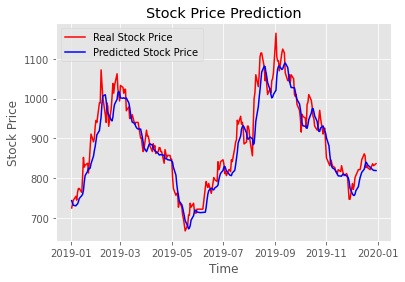

In [ ]:
# plot the results 
plt.plot(graph['Adj Close'], color = 'red', label = 'Real Stock Price')
plt.plot(graph['Predict_Value'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(df['Adj Close'], color = 'black', label = 'Past Stock')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [ ]:
final  = test_df.drop(test_df.index[0:36])
final.reset_index(inplace=True)
final.rename(columns = {'index':'Date'})
final = final.drop(columns=['High','Low','Open','Volume','Close'])
final['Predict_Value'] = predicted_y[0]
final['Selisih'] = final['Adj Close'] - final['Predict_Value']
final['Lost/Risk (%)'] = abs((final['Adj Close'] - final['Predict_Value'])/final['Predict_Value']*100)
final = final.drop(columns=['Adj Close'])

In [ ]:
percent = test_df.drop(test_df.index[0:35])
percent = percent.drop(test_df.index[-1])
percent.reset_index(inplace=True)
percent.rename(columns = {'index':'Date'}) 
percent = percent.drop(columns=['High','Low','Open','Volume','Close'])
percent['Next Day'] = predicted_y
percent['Plus or Minus']= percent['Adj Close'] - percent['Next Day']
percent['Next Day (%)']= abs(((percent['Adj Close'] - percent['Next Day'])/percent['Adj Close'])*100)

In [ ]:
True_Next_Day = test_df.drop(test_df.index[0:35])
True_Next_Day = True_Next_Day.drop(test_df.index[-1])
True_Next_Day.reset_index(inplace=True)
True_Next_Day.rename(columns = {'index':'Date'}) 
True_Next_Day = True_Next_Day.drop(columns=['High','Low','Open','Volume','Close'])
True_Next_Day['True Next Day'] = org_y
True_Next_Day['True Plus or Minus']= (True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])
True_Next_Day['True Next Day (%)']= abs(((True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])/True_Next_Day['Adj Close'])*100)
True_Next_Day = True_Next_Day.drop(columns=['Adj Close','True Next Day'])

In [ ]:
Concating = percent.merge(final, how='outer', on='Date')
Concating = Concating.merge(True_Next_Day, how='outer', on='Date')
#Concating.set_index('Date', inplace=True)
Final_Predict = Concating.copy()
Final_Predict['Harga Saham Hari ini'] = Concating['Adj Close']
Final_Predict['Prediksi Besok'] = Concating['Plus or Minus']
Final_Predict['Harga Besok Sebenarnya'] = Concating['True Plus or Minus']
Final_Predict['Prediksi Besok (%)'] = (Concating['Next Day (%)'])
Final_Predict['Harga Besok Sebenarnya (%)'] = Concating['True Next Day (%)']
Final_Predict['Selisih Prediksi'] = (Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])
Final_Predict['Risk/MAPE(%)'] = abs(((Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])/Final_Predict['Harga Besok Sebenarnya'])*100)
Final_Predict['Risk/MAPE(%)'] = round(Final_Predict['Risk/MAPE(%)'], 2)
Final_Predict = Final_Predict.drop(columns=['Adj Close', 'Next Day', 'Plus or Minus', 'Next Day (%)',
                                            'Predict_Value', 'Selisih', 'Lost/Risk (%)', 'True Plus or Minus',
                                            'True Next Day (%)'])
Final_Predict = Final_Predict.replace(0, np.nan)
Final_Predict = Final_Predict.dropna()
Final_Predict.set_index('Date', inplace=True)
Final_Predict.shape

(231, 7)

In [ ]:
Final_Predict.head()

,Harga Saham Hari ini,Prediksi Besok,Harga Besok Sebenarnya,Prediksi Besok (%),Harga Besok Sebenarnya (%),Selisih Prediksi,Risk/MAPE(%)
Date,,,,,,,
2019-01-01,749.183655,6.011963,24.483093,0.802469,3.267969,18.471130,75.44
2019-01-02,724.700562,-11.750122,-9.793213,1.621376,1.351346,1.956909,19.98
2019-01-03,734.493774,3.123352,-9.793213,0.425239,1.333328,-12.916565,131.89
2019-01-04,744.286987,14.132141,-9.793274,1.898749,1.315793,-23.925415,244.30
2019-01-07,754.080261,21.029724,9.793274,2.788791,1.298704,-11.236450,114.74


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

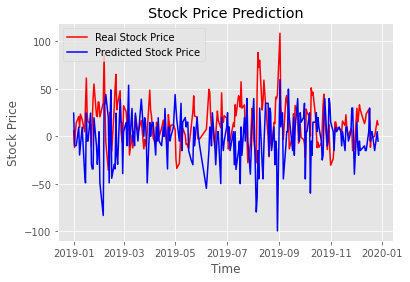

In [ ]:
# plot the results 
plt.plot(Final_Predict['Prediksi Besok'], color = 'red', label = 'Real Stock Price')
plt.plot(Final_Predict['Harga Besok Sebenarnya'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(Final_Predict['Risk/MAPE(%)'], color = 'black', label = 'RISK/MAPE(%)')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [ ]:
#### Mencari Data STAT MODEL

In [ ]:
a = X_test
a = np.reshape(a, (-1, 36))
a = scaler.inverse_transform(a)
a = pd.DataFrame(a)

In [ ]:
b = y_test
#b = np.reshape(b, (-1, 36))
b = scaler.inverse_transform(b)
b = pd.DataFrame(b)

In [ ]:
#OLS Model
import statsmodels.api as sm
X = a
Y = b
X = sm.add_constant(X)
model_ols = sm.OLS(Y,X)
results = model_ols.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     143.6
Date:                Thu, 15 Apr 2021   Prob (F-statistic):          1.18e-132
Time:                        19:02:14   Log-Likelihood:                -1156.3
No. Observations:                 256   AIC:                             2387.
Df Residuals:                     219   BIC:                             2518.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3140     16.168      3.112      0.002      18.450      82.178
0              0.0584      0.063      0.920      0.358      -0.067       0.183
1             -0.0659      0.087     -0.755      0.451      -0.238       0.106
2              0.0307      0.087      0.351      0.726      -0.141       0.203
3             -0.0725      0.087     -0.830      0.407      -0.244       0.100
4             -0.0218      0.087     -0.250      0.803      -0.194       0.150
5              0.0178      0.088      0.202      0.840      -0.155       0.191
6              0.0315      0.088      0.357      0.721      -0.142       0.205
7             -0.0219      0.089     -0.247      0.805      -0.197       0.153
8             -0.0365      0.089     -0.409      0.683      -0.212       0.139
9              0.2115      0.088      2.394      0.018       0.037       0.386
10            -0.1701      0.088     -1.938      0.054      -0.343       0.003
11            -0.0129      0.088     -0.147      0.884      -0.186       0.160
12             0.0236      0.088      0.269      0.788      -0.150       0.197
13             0.0549      0.088      0.625      0.533      -0.118       0.228
14            -0.1624      0.090     -1.807      0.072      -0.339       0.015
15             0.1312      0.093      1.414      0.159      -0.052       0.314
16            -0.1052      0.093     -1.128      0.260      -0.289       0.079
17            -0.0610      0.093     -0.654      0.514      -0.245       0.123
18             0.0984      0.093      1.060      0.290      -0.085       0.281
19             0.0740      0.093      0.798      0.426      -0.109       0.257
20            -0.0746      0.093     -0.801      0.424      -0.258       0.109
21            -0.0350      0.093     -0.374      0.709      -0.219       0.149
22             0.0518      0.094      0.551      0.582      -0.133       0.237
23             0.0137      0.094      0.146      0.884      -0.172       0.199
24             0.0301      0.094      0.319      0.750      -0.156       0.216
25            -0.0402      0.095     -0.425      0.672      -0.227       0.146
26             0.1439      0.095      1.514      0.132      -0.043       0.331
27            -0.1967      0.095     -2.065      0.040      -0.385      -0.009
28             0.1757      0.095      1.858      0.065      -0.011       0.362
29            -0.0905      0.094     -0.960      0.338      -0.276       0.095
30            -0.0891      0.094     -0.948      0.344      -0.274       0.096
31             0.1501      0.093      1.607      0.110      -0.034       0.334
32            -0.0451      0.093     -0.483      0.630      -0.229       0.139
33             0.0371      0.093      0.397      0.691      -0.147       0.221
34            -0.0534      0.093     -0.572      0.568      -0.238       0.131
35